# Tensorflow - 01
# Writing Effective bayesian programs using TensorFlow and TFP
+ [Colab Notebook](https://colab.research.google.com/drive/19VAyIybEDHjGTt8n7ogzhaPGbOSzW6cN#scrollTo=SxVzrw2cO-Kx)
+ [Youtube - Junpeng Lao: Writing effective bayesian programs using TensorFlow and TFP | PyData Córdoba](https://www.youtube.com/watch?v=zWXTpZX4PPo&t=1005s)

In [1]:
import pymc3 as pm
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
from scipy import stats
import bambi as bmb
import seaborn as sns
import plotnine as p9
from plotnine import *

import theano.tensor as tt
import theano

import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp

tf.enable_v2_behavior()

tfd = tfp.distributions
tfb = tfp.bijectors

import datetime
print(f"Last Run {datetime.datetime.now()}")

Last Run 2023-05-29 20:10:29.600991


In [2]:
tf.enable_v2_behavior()

dtype = tf.float64

az.style.use("arviz-grayscale")
# plt.rcParams['figure.dpi'] = 300
pd.set_option('display.max_columns', 500)

sns.reset_defaults()
#sns.set_style('whitegrid')
#sns.set_context('talk')
sns.set_context(context='talk', font_scale=0.7)

# %config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [3]:
# tf.enable_v2_behavior()

# # az.style.use("arviz-grayscale")
# # plt.rcParams['figure.dpi'] = 300 
# # themes.theme_set('theme_bw')
# az.style.use("arviz-grayscale")
# # plt.rcParams['figure.dpi'] = 300
# pd.set_option('display.max_columns', 500)

# sns.reset_defaults()
# #sns.set_style('whitegrid')
# #sns.set_context('talk')
# sns.set_context(context='talk', font_scale=0.7)

In [4]:
%load_ext watermark
%watermark --iversions

pandas                : 1.3.2
theano                : 1.1.2
seaborn               : 0.11.2
arviz                 : 0.11.2
tensorflow_probability: 0.15.0
plotnine              : 0.8.0
tensorflow            : 2.7.0
pymc3                 : 3.11.4
numpy                 : 1.19.5
scipy                 : 1.7.1
bambi                 : 0.6.3
matplotlib            : 3.4.3



In [5]:
if tf.test.gpu_device_name() != '/device:GPU:0':
  print('WARNING: GPU device not found.')
else:
  print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

SUCCESS: Found GPU: /device:GPU:0


## Small primer using linear regression

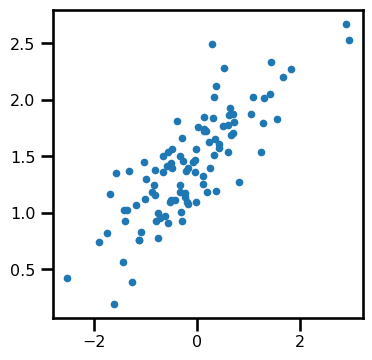

In [6]:
N = 100
X = np.random.randn(N, 1)
beta, c, eps = .4, 1.5, .3
y = X*beta + c + np.random.randn(N, 1)*eps

fig, ax = plt.subplots(figsize=(4,4))
plt.plot(X, y, '.');

Linear regression model: $${\boldsymbol {y}} = X@{\boldsymbol {\beta }} + intercept + \epsilon, \epsilon \sim Normal(0, \sigma)$$
$$ {\boldsymbol {\hat {\beta }}}=(X^{T}X)^{-1}X^{T}{\boldsymbol {y}} $$

Its Bayesian counterpart
$$ 
\begin{array}{rcl} 
{\boldsymbol {\beta }} &\sim& \text{Normal}(0, 10) \\
a &\sim& \text{Normal}(0, 10) \\
\sigma &\sim& \text{Gamma}(2, 5) \\
{\boldsymbol {\hat {y}}} &=& X@{\boldsymbol {\beta }} + a \\
{\boldsymbol {y}} &\sim& \text{Normal}({\boldsymbol {\hat {y}}}, \sigma)
\end{array}
$$

In [7]:
# reads global X - 100 simulated X points from cell above 
def forward_random(n_replica):
    # coefficient prior
    beta_samples = tfd.Normal(0.0, 10.0).sample(n_replica)
    # intercept_prior
    c_samples = tfd.Normal(0.0, 10.0).sample(n_replica)
    # error prior
    sigma_samples = tfd.Gamma(2.0, 5.0).sample(n_replica)
    
    # linear func.
    # manipulate shape so shapes line up between 9 samples for beta, intercept and 100 X points
    y_hat = beta_samples[tf.newaxis, ...]* X + c_samples[tf.newaxis, ...]
    # print(X)
    # likelihood
    y_samples = tfd.Normal(y_hat, sigma_samples[tf.newaxis, ...]).sample()
    return beta_samples, c_samples, sigma_samples, y_hat, y_samples

beta_samples, c_samples, sigma_samples, y_hat, y_samples = forward_random(9)
beta_samples

<tf.Tensor: shape=(9,), dtype=float32, numpy=
array([ -9.641565  , -12.399345  ,   9.809902  ,   0.94738   ,
        -3.856716  , -23.951008  ,   0.44336393,  -1.2202072 ,
        -7.371153  ], dtype=float32)>

In [8]:
beta_samples.shape

TensorShape([9])

In [9]:
sigma_samples.shape

TensorShape([9])

In [10]:
y_samples.shape

TensorShape([100, 9])

In [11]:
y_hat.shape

TensorShape([100, 9])

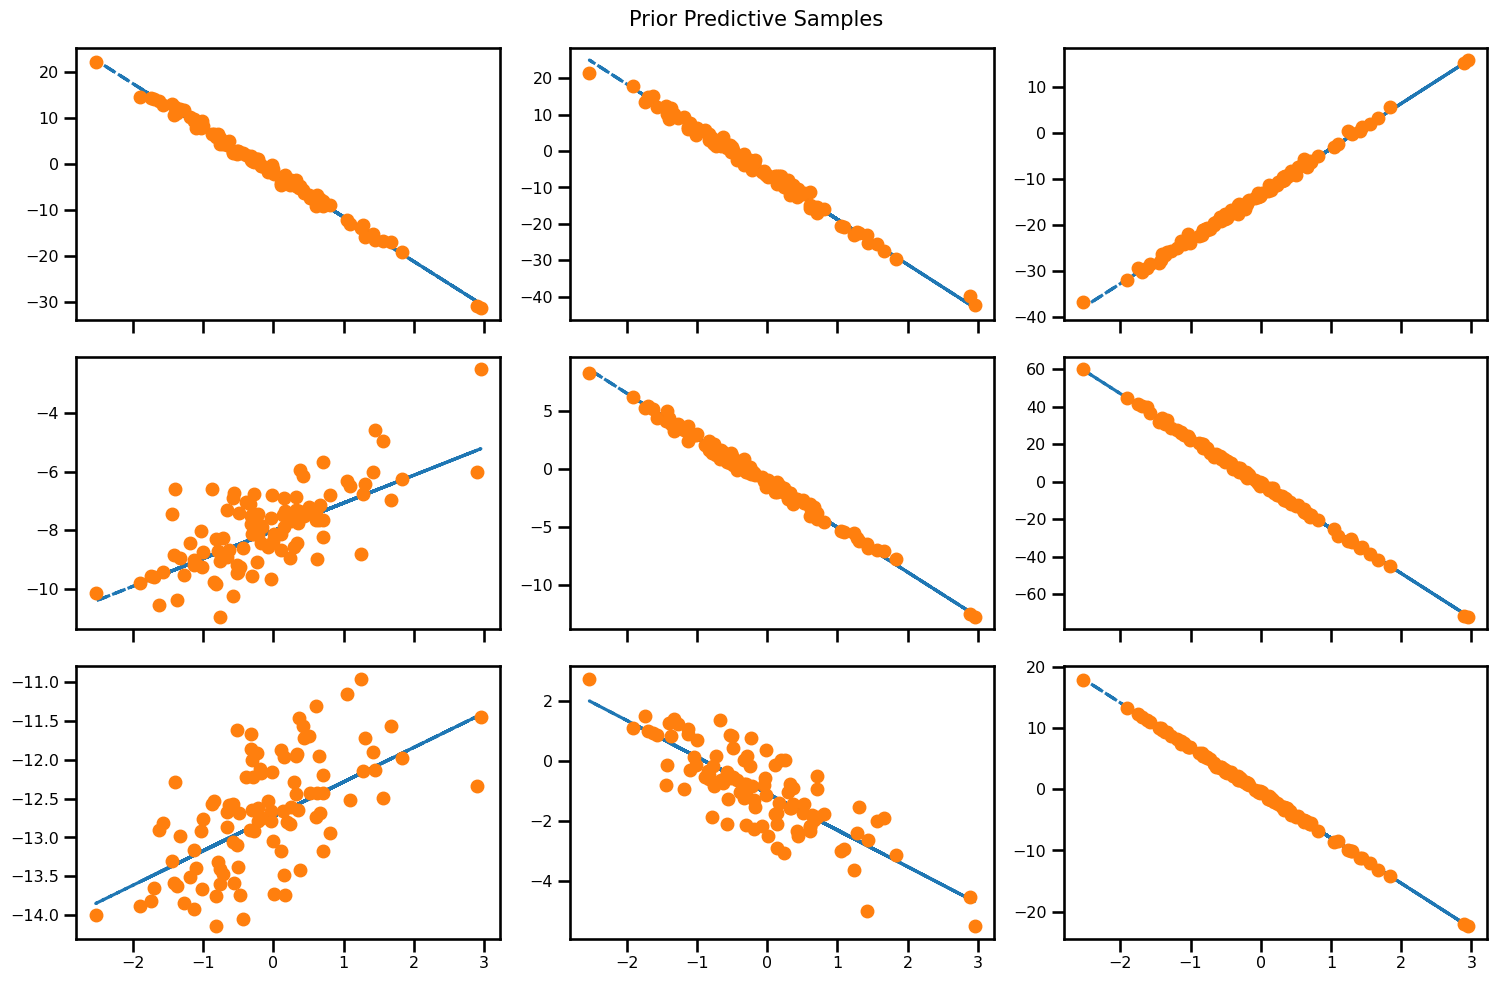

In [12]:
_, ax = plt.subplots(3, 3, figsize=(15, 10), sharex=True)
ax = ax.flatten()
for i in range(9):
  ax[i].plot(X, y_hat[:, i].numpy(), '--')
  ax[i].plot(X, y_samples[:, i].numpy(), 'o')
plt.suptitle('Prior Predictive Samples');
plt.tight_layout();

In [13]:
# Setup log likelihood function to use for inference
def backward_logprob(beta, c, sigma):
    # likelihood for coeff
    beta_logprob = tfd.Normal(0.0, 10.0).log_prob(beta)
    # likelihood for intercept
    c_logprob = tfd.Normal(0.0, 10.0).log_prob(c)
    # liklelihood for sigma
    sigma_logprob = tfd.Gamma(2.0, 5.0).log_prob(sigma)
    # linear func
    y_hat = beta[tf.newaxis, ...] * X + c[tf.newaxis, ...]
    # likelihood
    y_logprob = tfd.Normal(y_hat, sigma[tf.newaxis, ...]).log_prob(y)
    return beta_logprob + c_logprob + sigma_logprob + tf.reduce_sum(y_logprob, axis=0)

backward_logprob(beta_samples, c_samples, sigma_samples)    

<tf.Tensor: shape=(9,), dtype=float32, numpy=
array([ -9470.891  ,  -5662.083  , -60484.344  ,  -4966.1953 ,
        -9905.584  , -52052.08   , -23257.518  ,   -615.60956,
       -96604.06   ], dtype=float32)>

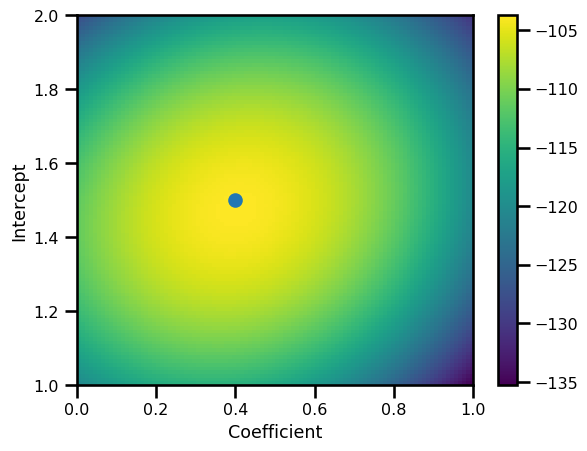

In [14]:
eps_conditional = 1.
beta_min, beta_max = 0., 1.
c_min, c_max = 1., 2.
beta_range = np.linspace(beta_min, beta_max, 100)
c_rage = np.linspace(c_min, c_max, 100)

beta_grid, c_grid = np.meshgrid(beta_range, c_rage)
log_prob_flatten = backward_logprob(*[tf.cast(x, tf.float32) 
  for x in [beta_grid.flatten(), c_grid.flatten(), np.ones(100*100)*eps_conditional]])
log_prob_grid = np.reshape(log_prob_flatten, [100, 100])
ax = plt.imshow(log_prob_grid, origin='lower', cmap='viridis',
           extent=[beta_min, beta_max, c_min, c_max], aspect='auto')
plt.colorbar(ax)
plt.scatter(beta, c)
plt.xlabel('Coefficient')
plt.ylabel('Intercept');

In [15]:
## Robust Linear Regression

In [16]:
#@title Get data
#@markdown Cut & pasted directly from the `fetch_hogg2010test()` function.
# It is identical to the original dataset as hardcoded in the Hogg 2010 paper
dfhogg = pd.DataFrame(np.array([[1, 201, 592, 61, 9, -0.84],
                                 [2, 244, 401, 25, 4, 0.31],
                                 [3, 47, 583, 38, 11, 0.64],
                                 [4, 287, 402, 15, 7, -0.27],
                                 [5, 203, 495, 21, 5, -0.33],
                                 [6, 58, 173, 15, 9, 0.67],
                                 [7, 210, 479, 27, 4, -0.02],
                                 [8, 202, 504, 14, 4, -0.05],
                                 [9, 198, 510, 30, 11, -0.84],
                                 [10, 158, 416, 16, 7, -0.69],
                                 [11, 165, 393, 14, 5, 0.30],
                                 [12, 201, 442, 25, 5, -0.46],
                                 [13, 157, 317, 52, 5, -0.03],
                                 [14, 131, 311, 16, 6, 0.50],
                                 [15, 166, 400, 34, 6, 0.73],
                                 [16, 160, 337, 31, 5, -0.52],
                                 [17, 186, 423, 42, 9, 0.90],
                                 [18, 125, 334, 26, 8, 0.40],
                                 [19, 218, 533, 16, 6, -0.78],
                                 [20, 146, 344, 22, 5, -0.56]]),
                   columns=['id','x','y','sigma_y','sigma_x','rho_xy'])


## for convenience zero-base the 'id' and use as index
dfhogg['id'] = dfhogg['id'] - 1
dfhogg.set_index('id', inplace=True)

## standardize (mean center and divide by 1 sd)
dfhoggs = (dfhogg[['x','y']] - dfhogg[['x','y']].mean(0)) / dfhogg[['x','y']].std(0)
dfhoggs['sigma_y'] = dfhogg['sigma_y'] / dfhogg['y'].std(0)
dfhoggs['sigma_x'] = dfhogg['sigma_x'] / dfhogg['x'].std(0)

dfhoggs.head()

,x,y,sigma_y,sigma_x
id,,,,
0.0,0.494793,1.685772,0.595955,0.159897
1.0,1.258746,-0.180252,0.244244,0.071065
2.0,-2.241225,1.597844,0.371251,0.195430
3.0,2.022699,-0.170482,0.146546,0.124364
4.0,0.530326,0.738105,0.205165,0.088832


In [17]:
dfhoggs.describe()

,x,y,sigma_y,sigma_x
count,2.000000e+01,2.000000e+01,20.000000,20.000000
mean,-9.436896e-17,1.165734e-16,0.263783,0.116370
std,1.000000e+00,1.000000e+00,0.127972,0.039716
min,-2.241225e+00,-2.407757e+00,0.136777,0.071065
25%,-3.357840e-01,-7.542252e-01,0.156316,0.088832
50%,5.063410e-02,-1.020940e-01,0.244244,0.106598
75%,5.170008e-01,7.600871e-01,0.310190,0.146572
max,2.022699e+00,1.685772e+00,0.595955,0.195430


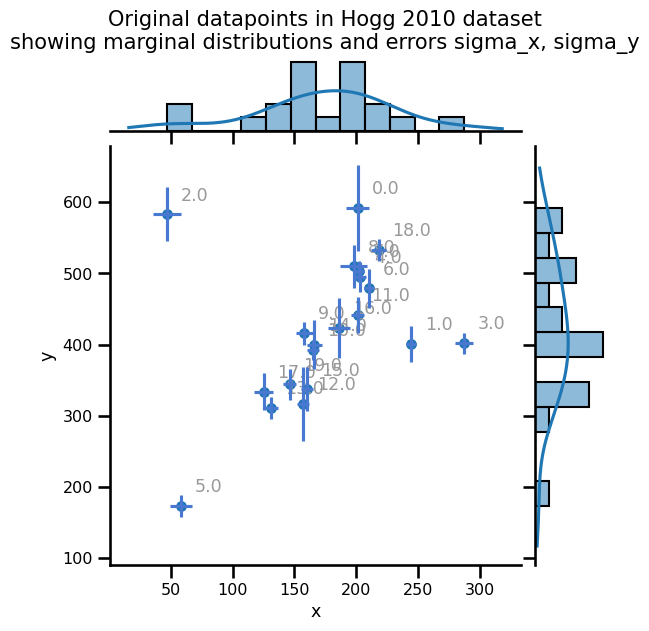

In [18]:
with plt.rc_context({"figure.constrained_layout.use": False}):
    gd = sns.jointplot(
        x="x",
        y="y",
        data=dfhogg,
        kind="scatter",
        height=6,
        marginal_kws={"bins": 12, "kde": True, "kde_kws": {"cut": 1}},
        joint_kws={"edgecolor": "w", "linewidth": 1.2, "s": 80},
    )

_ = gd.ax_joint.errorbar(
    "x", "y", "sigma_y", "sigma_x", fmt="none", ecolor="#4878d0", data=dfhogg, zorder=10
)

for idx, r in dfhogg.iterrows():
    _ = gd.ax_joint.annotate(
        text=idx,
        xy=(r["x"], r["y"]),
        xycoords="data",
        xytext=(10, 10),
        textcoords="offset points",
        color="#999999",
        zorder=1,
    )


_ = gd.fig.suptitle(
    (
        "Original datapoints in Hogg 2010 dataset\n"
        + "showing marginal distributions and errors sigma_x, sigma_y"
    ),
    y=1.05,
);

/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.


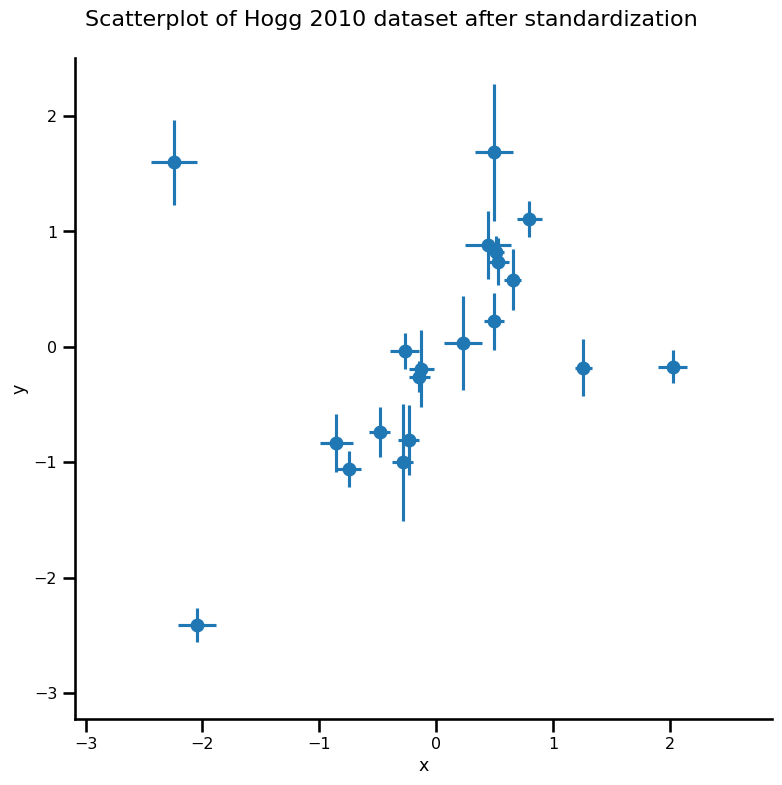

In [19]:
def plot_hoggs(dfhoggs):
  ## create xlims ylims for plotting
  xlims = (dfhoggs['x'].min() - np.ptp(dfhoggs['x'])/5,
           dfhoggs['x'].max() + np.ptp(dfhoggs['x'])/5)
  ylims = (dfhoggs['y'].min() - np.ptp(dfhoggs['y'])/5,
           dfhoggs['y'].max() + np.ptp(dfhoggs['y'])/5)

  ## scatterplot the standardized data
  g = sns.FacetGrid(dfhoggs, size=8)
  _ = g.map(plt.errorbar, 'x', 'y', 'sigma_y', 'sigma_x', marker="o", ls='')
  _ = g.axes[0][0].set_ylim(ylims)
  _ = g.axes[0][0].set_xlim(xlims)

  plt.subplots_adjust(top=0.92)
  _ = g.fig.suptitle('Scatterplot of Hogg 2010 dataset after standardization', fontsize=16)
  return g, xlims, ylims
  
g = plot_hoggs(dfhoggs)

In [20]:
X_np = dfhoggs['x'].values
sigma_y_np = dfhoggs['sigma_y'].values
Y_np = dfhoggs['y'].values

In [21]:
mdl_ols = tfd.JointDistributionSequential([

    # b0 ~ Normal(0, 1)
    tfd.Normal(loc=tf.cast(0, dtype), scale=1.),
    # b1 ~ Normal(0, 1)
    tfd.Normal(loc=tf.cast(0, dtype), scale=1.),
    # y  ~ Normal(b0+b1*X, sigma_y)
    lambda b1, b0: tfd.Normal(
      # Parameter transformation
      loc=b0 + b1*X_np,
      scale=sigma_y_np)
])

In [22]:
mdl_ols.resolve_graph()

(('b0', ()), ('b1', ()), ('x', ('b1', 'b0')))

In [23]:
mdl_ols.sample()

[<tf.Tensor: shape=(), dtype=float64, numpy=-0.2283762679411403>,
 <tf.Tensor: shape=(), dtype=float64, numpy=-1.4149332958434961>,
 <tf.Tensor: shape=(20,), dtype=float64, numpy=
 array([-1.13321483, -2.19724593,  2.77372007, -2.9633988 , -1.14660743,
         2.63592341, -0.98893792, -0.96564228, -0.99736453, -0.06074561,
        -0.07437241, -0.34628326,  0.25848823,  0.82876761,  0.10103879,
         0.17591808, -1.15324655,  1.20262828, -1.12572769,  0.91184622])>]

In [24]:
b0, b1, y = mdl_ols.sample()
mdl_ols.log_prob([b0, b1, y])

<tf.Tensor: shape=(20,), dtype=float64, numpy=
array([-2.45108989, -2.36758158, -2.1750902 , -1.06401086, -1.97610218,
       -1.06081738, -1.63638288, -2.84906626, -1.83480126, -1.1448227 ,
       -1.25716512, -1.75102968, -2.39870308, -1.11306156, -1.94246465,
       -2.08721113, -2.63424853, -4.09529625, -1.47335777, -1.67007345])>

In [25]:
mdl_ols.log_prob_parts([b0, b1, y])

[<tf.Tensor: shape=(), dtype=float64, numpy=-0.920360381017194>,
 <tf.Tensor: shape=(), dtype=float64, numpy=-1.1291042694030746>,
 <tf.Tensor: shape=(20,), dtype=float64, numpy=
 array([-0.40162524, -0.31811693, -0.12562555,  0.98545379,  0.07336247,
         0.98864727,  0.41308177, -0.79960161,  0.21466339,  0.90464195,
         0.79229953,  0.29843497, -0.34923843,  0.93640309,  0.107     ,
        -0.03774648, -0.58478388, -2.0458316 ,  0.57610688,  0.3793912 ])>]

In [26]:
mdl_ols_ = tfd.JointDistributionSequential([
    # b0
    tfd.Normal(loc=tf.cast(0, dtype), scale=1.),
    # b1
    tfd.Normal(loc=tf.cast(0, dtype), scale=1.),
    # likelihood
    #   Using Independent to ensure the log_prob is not incorrectly broadcasted
    lambda b1, b0: tfd.Independent(
        tfd.Normal(
            # Parameter transformation
            # b1 shape: (batch_shape), X shape (num_obs): we want result to have shape (batch_shape, num_obs)
            loc=b0 + b1*X_np,
            scale=sigma_y_np),
        reinterpreted_batch_ndims=1
    ),
])

# mdl_ols_.log_prob_parts(mdl_ols_.sample(5))

In [27]:
def gen_ols_model(X, sigma, hyperprior_mean=0, hyperprior_scale=1):
  return tfd.JointDistributionSequential([
      # b0
      tfd.Normal(loc=tf.cast(hyperprior_mean, dtype),
                 scale=hyperprior_scale),
      # b1
      tfd.Normal(loc=tf.cast(hyperprior_mean, dtype),
                 scale=hyperprior_scale),
      # likelihood
      lambda b1, b0: tfd.Independent(
          tfd.Normal(
              # Parameter transformation
              loc=b0 + b1*X,
              scale=sigma),
          reinterpreted_batch_ndims=1
      ),
  ])

mdl_ols_ = gen_ols_model(X_np, sigma_y_np, 0., 10.)

In [28]:
print(mdl_ols_.sample_distributions()[0][-1])
print(mdl_ols.sample_distributions()[0][-1])

tfp.distributions.Independent("IndependentNormal", batch_shape=[], event_shape=[20], dtype=float64)
tfp.distributions.Normal("Normal", batch_shape=[20], event_shape=[], dtype=float64)


In [29]:
b0, b1, y = mdl_ols_.sample()
mdl_ols_.log_prob([b0, b1, y])  # <== Getting a scalar correctly

<tf.Tensor: shape=(), dtype=float64, numpy=-4.769256837431325>

In [30]:
mdl_ols_named = tfd.JointDistributionNamed(dict(
    likelihood = lambda b0, b1: tfd.Independent(
        tfd.Normal(
            loc=b0 + b1*X_np,
            scale=sigma_y_np),
        reinterpreted_batch_ndims=1
    ),
    b0         = tfd.Normal(loc=tf.cast(0, dtype), scale=1.),
    b1         = tfd.Normal(loc=tf.cast(0, dtype), scale=1.),
))
mdl_ols_named.sample()

{'b1': <tf.Tensor: shape=(), dtype=float64, numpy=-0.4208821402828758>,
 'b0': <tf.Tensor: shape=(), dtype=float64, numpy=0.762972675970565>,
 'likelihood': <tf.Tensor: shape=(20,), dtype=float64, numpy=
 array([ 0.36349153, -0.03854967,  1.63827248, -0.25840086,  0.59212581,
         1.80422169,  0.44989982,  0.60905983,  0.40326019,  1.12062564,
         0.9402358 ,  0.71205215,  1.06788643,  0.94763617,  0.86120347,
         0.71421241,  0.4091798 ,  1.18718085,  0.53111111,  0.97391009])>}

In [31]:
mdl_ols_named.log_prob({'b0': b0, 'b1': b1, 'likelihood': y})  # <== Getting a scalar correctly

<tf.Tensor: shape=(), dtype=float64, numpy=-54.10363578062653>

In [32]:
Root = tfd.JointDistributionCoroutine.Root  # Convenient alias.
def model():
  b1 = yield Root(tfd.Normal(loc=tf.cast(0, dtype), scale=1.))
  b0 = yield Root(tfd.Normal(loc=tf.cast(0, dtype), scale=1.))
  yhat = b0 + b1*X_np
  likelihood = yield tfd.Independent(
        tfd.Normal(loc=yhat, scale=sigma_y_np),
        reinterpreted_batch_ndims=1
    )

mdl_ols_coroutine = tfd.JointDistributionCoroutine(model)
mdl_ols_coroutine.sample()

StructTuple(
  var0=<tf.Tensor: shape=(), dtype=float64, numpy=-0.4406828148297109>,
  var1=<tf.Tensor: shape=(), dtype=float64, numpy=0.16761555214921026>,
  var2=<tf.Tensor: shape=(20,), dtype=float64, numpy=
    array([ 0.13449848, -0.88837784,  1.50114362, -0.81409848, -0.21615849,
            1.02572265, -0.11271976, -0.02576722, -0.14086018,  0.27556258,
            0.25149347,  0.19492278,  0.43701527,  0.50159943,  0.37309013,
           -0.63948475,  0.32861319,  0.6804145 , -0.04639193,  0.42897098])>
)

In [33]:
mdl_ols_coroutine.log_prob((b1, b0, y))  # <== Getting a scalar correctly

<tf.Tensor: shape=(), dtype=float64, numpy=-54.10363578062653>

In [34]:
# Small wrapper to get the neg_log_likelihood that outputs value with gradient
def neg_log_likelihood(x):
  def neg_log_p(x):
    return -tf.squeeze(mdl_ols_.log_prob([x[0], x[1], Y_np]))
  return tfp.math.value_and_gradient(neg_log_p, x)

lbfgs_results = tfp.optimizer.lbfgs_minimize(
    neg_log_likelihood,
    initial_position=tf.zeros(2, dtype=dtype),
    tolerance=1e-20,
    x_tolerance=1e-8
)

/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.


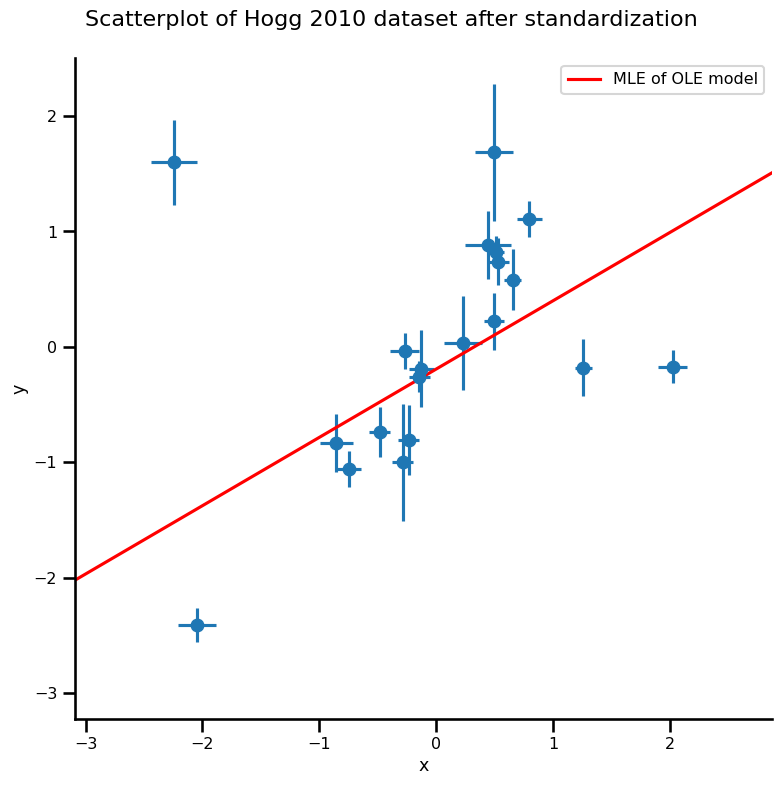

In [35]:
b0est, b1est = lbfgs_results.position.numpy()

g, xlims, ylims = plot_hoggs(dfhoggs);
xrange = np.linspace(xlims[0], xlims[1], 100)
g.axes[0][0].plot(xrange, b0est + b1est*xrange, 
                  color='r', label='MLE of OLE model')
plt.legend();

#### Batched version model